Fieldtrip: Audio Vs Visual Vs Motor
===================================

Lead authors: Hadi Zaatiti <hadi.zaatiti@nyu.edu>

- Description of experiment
The `Audio vs Visual vs Motor` code experiment in `Psychtoolbox` can be found here:

[Auditory vs Visual vs Motor](https://github.com/Hzaatiti/meg-pipeline/blob/main/experiments/psychtoolbox/auditory-vs-visual/auditory_vs_visual.m)

Importing data 
--------------

The data used in this notebook is hosted on `NYU BOX`. Permissions are given upon request.

- Install the BOX app from [here](https://www.box.com/resources/downloads)
- Set an environment variable with name `MEG_DATA` to the path of the Data folder e.g.,
    - `C:\Users\user_name\Box\MEG\Data`
    - or `C:\Users\user_name\Box\Data

MATLAB setup
------------

Make sure that:
- Fieldtrip is installed in MATLAB
- Add to MATLAB path the custom-made functions for NYUAD MEG lab found [here](https://github.com/Hzaatiti/meg-pipeline/tree/main/pipeline/field_trip_pipelines/matlab_functions)

Each experiment run using the KIT system generates a `.con` file and two or more .mrk files.

In [1]:
%% FieldTrip pipeline for audio-visual-motor experiment
% Author: Hadi Zaatiti <hadi.zaatiti@nyu.edu>


clear;

% Reminder of stimulus types:

% 1 is visual stimulus = ch224
% 2 is auditory stimulus = ch225
% 3 is motor button = ch226

% Read the environment variable to NYU BOX
MEG_DATA_FOLDER = getenv('MEG_DATA');


% Define paths
TASK_NAME = 'audio-visual-motor';
SYSTEM = 'meg-kit';
SUB_ID = 'sub-001';
LASER_DEVICE = 'laser-scan';


% Construct the directory path
DATA_FOLDER_PATH = fullfile(MEG_DATA_FOLDER, TASK_NAME, SUB_ID, SYSTEM);

% List all .con files with the prefix 'sub-001'
filePattern = fullfile(DATA_FOLDER_PATH, [SUB_ID,'*.con']);
conFiles = dir(filePattern);


% Display the file names
disp('Found .con files:');
for k = 1:length(conFiles)
    disp(conFiles(k).name);
end


filePattern_mrk = fullfile(DATA_FOLDER_PATH, '*.mrk');

mrkFiles = dir(filePattern_mrk);

% Construct the directory path
DATA_FOLDER_PATH_LASER = fullfile(MEG_DATA_FOLDER, TASK_NAME, SUB_ID, LASER_DEVICE);

filePattern_laser_surface = fullfile(DATA_FOLDER_PATH_LASER,  [SUB_ID,'*basic-surface.txt']);
filePattern_laser_stylus = fullfile(DATA_FOLDER_PATH_LASER,  [SUB_ID,'*stylus-points.txt']);

laser_points = dir(filePattern_laser_surface);
laser_surf = dir(filePattern_laser_stylus);


APPLY_FILTERS = false;


Found .con files:
sub-001_audio-visual_session-1.con
sub-001_audio-visual_session-2.con
sub-001_audio-visual_session-3.con


We will skip filtering and see the analysis results with and without.

In [ ]:
%% Filtering data

if APPLY_FILTERS
    % Notch filter the data at 50 Hz
    cfg = [];
    cfg.bsfilter = 'yes';
    cfg.bsfreq = [49 51]; % Notch filter range
    combinedData = ft_preprocessing(cfg, combinedData);

    % Band-pass filter the data
    cfg = [];
    cfg.bpfilter = 'yes';
    cfg.bpfreq = [4 40]; % Band-pass filter range
    cfg.bpfiltord = 4;   % Filter order
    combinedData = ft_preprocessing(cfg, combinedData);
    
    disp('Filtering operations complete on combined data.');
end

In [2]:
%%

% Initialize FieldTrip configuration
cfg = [];
cfg.coilaccuracy = 0;

% Cell array to store preprocessed data
dataList = {};

% Loop through all .con files
for k = 1:length(conFiles)
    % Construct the full path for the current .con file
    conFile = fullfile(DATA_FOLDER_PATH, conFiles(k).name);
    
    % Set the dataset in the configuration
    cfg.dataset = conFile;
    
    % Preprocess the MEG data
    fprintf('Processing file: %s\n', conFiles(k).name);
    dataList{k} = ft_preprocessing(cfg); % Store preprocessed data in the list
end

% Concatenate all preprocessed data
fprintf('Concatenating all preprocessed data...\n');
combinedData = ft_appenddata([], dataList{:});

% Display a message when concatenation is complete
disp('Data concatenation complete.');

Processing file: sub-001_audio-visual_session-1.con
-------------------------------------------------------------------------------------------
FieldTrip is developed by members and collaborators of the Donders Institute for Brain,
Cognition and Behaviour at Radboud University, Nijmegen, the Netherlands.

                          --------------------------
                        /                            \
                     ------------------------------------
                    /                                    \
          -------------------------------------------------
         /                            /\/\/\/\/\ 
         ---------------------------------------------------
                  |        F  i  e  l  d  T  r  i  p       |
                  ------------------------------------------
                   \                                      /
                     ------------------------------------
                          \            /
                

concatenating over the "rpt" dimension
the call to "ft_selectdata" took 0 seconds
the call to "ft_appenddata" took 0 seconds
Data concatenation complete.


In [1]:
%% Define trials and segmentation of the data


previewTrigger = combinedData.trial{1}(225, :);

threshold = (max(previewTrigger) + min(previewTrigger)) / 2;
    
trigger_channels = [225, 226, 227];

TRIALS_DEF = cell(length(conFiles), length(trigger_channels));
TRIALS = cell(length(conFiles), length(trigger_channels));

for fileIdx = 1:length(conFiles)

    for chIdx = 1:length(trigger_channels)
        cfg = [];
        conFile = fullfile(DATA_FOLDER_PATH, conFiles(fileIdx).name);
        cfg.dataset  = conFile;
        cfg.trialdef.eventvalue = 1; % placeholder for the conditions
        cfg.trialdef.prestim    = 0.5; % 1s before stimulus onset
        cfg.trialdef.poststim   = 1.2; % 1s after stimulus onset
        cfg.trialfun = 'ft_trialfun_general';
        cfg.trialdef.chanindx = trigger_channels(chIdx);
        cfg.trialdef.threshold = threshold;
        cfg.trialdef.eventtype = 'combined_binary_trigger'; % this will be the type of the event if combinebinary = true
        cfg.trialdef.combinebinary = 1;
        cfg.preproc.baselinewindow = [-0.2 0];
        cfg.preproc.demean     = 'yes';
    
        % Define trials for the current channel and dataset
        TRIALS_DEF{fileIdx, chIdx} = ft_definetrial(cfg);

        % Preprocess trials for the current channel and dataset
        TRIALS{fileIdx, chIdx} = ft_preprocessing(TRIALS_DEF{fileIdx, chIdx});
    end
end

evaluating trial function 'ft_trialfun_general'
reading the header from 'C:\Users\hz3752\Box\MEG\Data\audio-visual-motor\sub-001\meg-kit\sub-001_audio-visual_session-1.con'
reading the events from 'C:\Users\hz3752\Box\MEG\Data\audio-visual-motor\sub-001\meg-kit\sub-001_audio-visual_session-1.con'
found 50 events
created 50 trials
the call to "ft_definetrial" took 4 seconds
processing channel { 'AG001' 'AG002' 'AG003' 'AG004' 'AG005' 'AG006' 'AG007' 'AG008' 'AG009' 'AG010' 'AG011' 'AG012' 'AG013' 'AG014' 'AG015' 'AG016' 'AG017' 'AG018' 'AG019' 'AG020' 'AG021' 'AG022' 'AG023' 'AG024' 'AG025' 'AG026' 'AG027' 'AG028' 'AG029' 'AG030' 'AG031' 'AG032' 'AG033' 'AG034' 'AG035' 'AG036' 'AG037' 'AG038' 'AG039' 'AG040' 'AG041' 'AG042' 'AG043' 'AG044' 'AG045' 'AG046' 'AG047' 'AG048' 'AG049' 'AG050' 'AG051' 'AG052' 'AG053' 'AG054' 'AG055' 'AG056' 'AG057' 'AG058' 'AG059' 'AG060' 'AG061' 'AG062' 'AG063' 'AG064' 'AG065' 'AG066' 'AG067' 'AG068' 'AG069' 'AG070' 'AG071' 'AG072' 'AG073' 'AG074' 'AG075' 'AG

In [2]:
%% Trials Concantenation

TRIALS_STIM = cell( length(trigger_channels),1);

for chIdx = 1:length(trigger_channels)
            cfg = [];
            TRIALS_STIM{chIdx} = ft_appenddata(cfg, TRIALS{1,chIdx}, TRIALS{2,chIdx}, TRIALS{3, chIdx});
end




concatenating over the "rpt" dimension
the call to "ft_selectdata" took 0 seconds
the call to "ft_appenddata" took 0 seconds


concatenating over the "rpt" dimension
the call to "ft_selectdata" took 0 seconds
the call to "ft_appenddata" took 0 seconds


concatenating over the "rpt" dimension
the call to "ft_selectdata" took 0 seconds
the call to "ft_appenddata" took 0 seconds


In [3]:
%% Visual Inspection ALTL

TRIALS_STIM_REJ = cell( length(trigger_channels),1);

for tr = 1:length(TRIALS_STIM)
    
    cfg = [];
    cfg.method='summary';
    cfg.channel = {'AG*'};
    TRIALS_STIM_REJ{tr} = ft_rejectvisual(cfg, TRIALS_STIM{tr});

end

save TRIALS_STIM_REJ TRIALS_STIM_REJ

the input is raw data with 256 channels and 150 trials
before GUI interaction: 150 trials marked to INCLUDE, 0 trials marked to EXCLUDE
before GUI interaction: 207 channels marked to INCLUDE, 49 channels marked to EXCLUDE
showing a summary of the data for all channels and trials
computing var [-----------------|                                         computing var [---------------------------------------/                   computing var [------------------------------------------------------------]
after GUI interaction: 141 trials marked to INCLUDE, 9 trials marked to EXCLUDE
after GUI interaction: 207 channels marked to INCLUDE, 49 channels marked to EXCLUDE
the following channels were removed: RM092, RM209, RM210, RM211, RM212, RM213, RM214, RM215, RM216, RM217, RM218, RM219, RM220, RM221, RM222, RM223, RM224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256
the following t

In [4]:
%% Averaging

AVG_TRIALS = cell( length(trigger_channels),1);

for tr = 1:length(AVG_TRIALS)

    cfg = [];

    AVG_TRIALS{tr} = ft_timelockanalysis(cfg, TRIALS_STIM_REJ{tr});

end

the input is raw data with 207 channels and 141 trials
the call to "ft_selectdata" took 0 seconds
the call to "ft_timelockanalysis" took 1 seconds
the input is raw data with 206 channels and 147 trials
the call to "ft_selectdata" took 0 seconds
the call to "ft_timelockanalysis" took 1 seconds
the input is raw data with 207 channels and 148 trials
the call to "ft_selectdata" took 0 seconds
the call to "ft_timelockanalysis" took 1 seconds


creating layout from cfg.grad
creating layout for yokogawa208 system
the call to "ft_prepare_layout" took 1 seconds
reading layout from file CTF151_helmet.mat
reading 'layout' from file 'CTF151_helmet.mat'
the call to "ft_prepare_layout" took 0 seconds


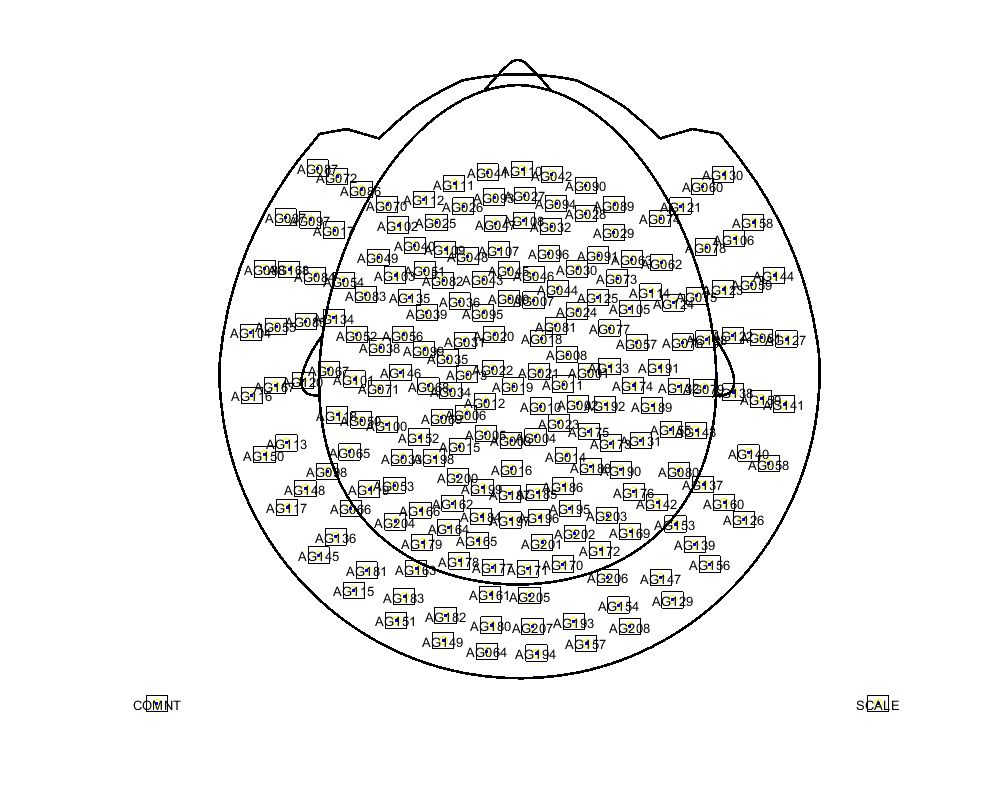

In [5]:
%% Get KIT Sensors

kit_layout = create_kit_layout(conFile);

figure('Position', [100, 100, 1000, 800]); % Adjust the width and height (1000 and 800) as needed
ft_plot_layout(kit_layout, 'box', 1);



the call to "ft_prepare_layout" took 0 seconds


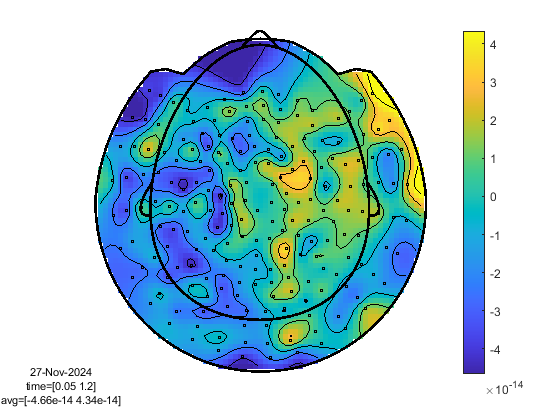

the call to "ft_selectdata" took 0 seconds
the call to "ft_topoplotER" took 2 seconds
the call to "ft_prepare_layout" took 0 seconds


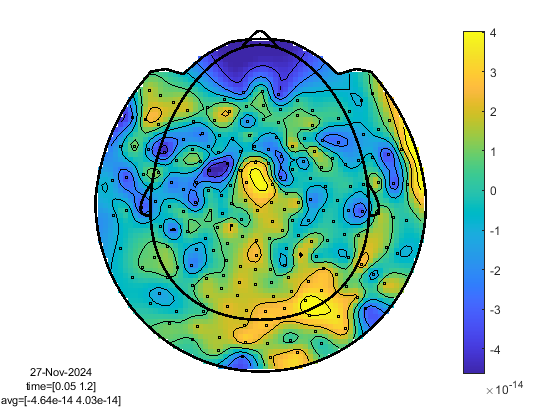

the call to "ft_selectdata" took 0 seconds
the call to "ft_topoplotER" took 1 seconds
the call to "ft_prepare_layout" took 0 seconds


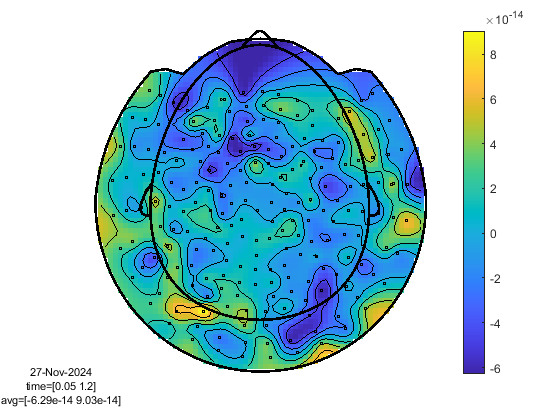

the call to "ft_selectdata" took 0 seconds
the call to "ft_topoplotER" took 1 seconds


In [6]:
%% Plotting in space

% for a single trial type, for each channel, average over time the trial
% and plot the average value on the helmet

% You can still see the time behavior when clicking on one sensor

for tr = 1:length(AVG_TRIALS)

    cfg = [];
    cfg.xlim = [0.05 1.2];
    cfg.colorbar = 'yes';
    cfg.layout = kit_layout;
    ft_topoplotER(cfg, AVG_TRIALS{tr});

end

Visual stimulus ERP select from the first plot sensors in the Occipital lobe and visualise the averaged ERP from the sensors
- Observe the M100 and M170

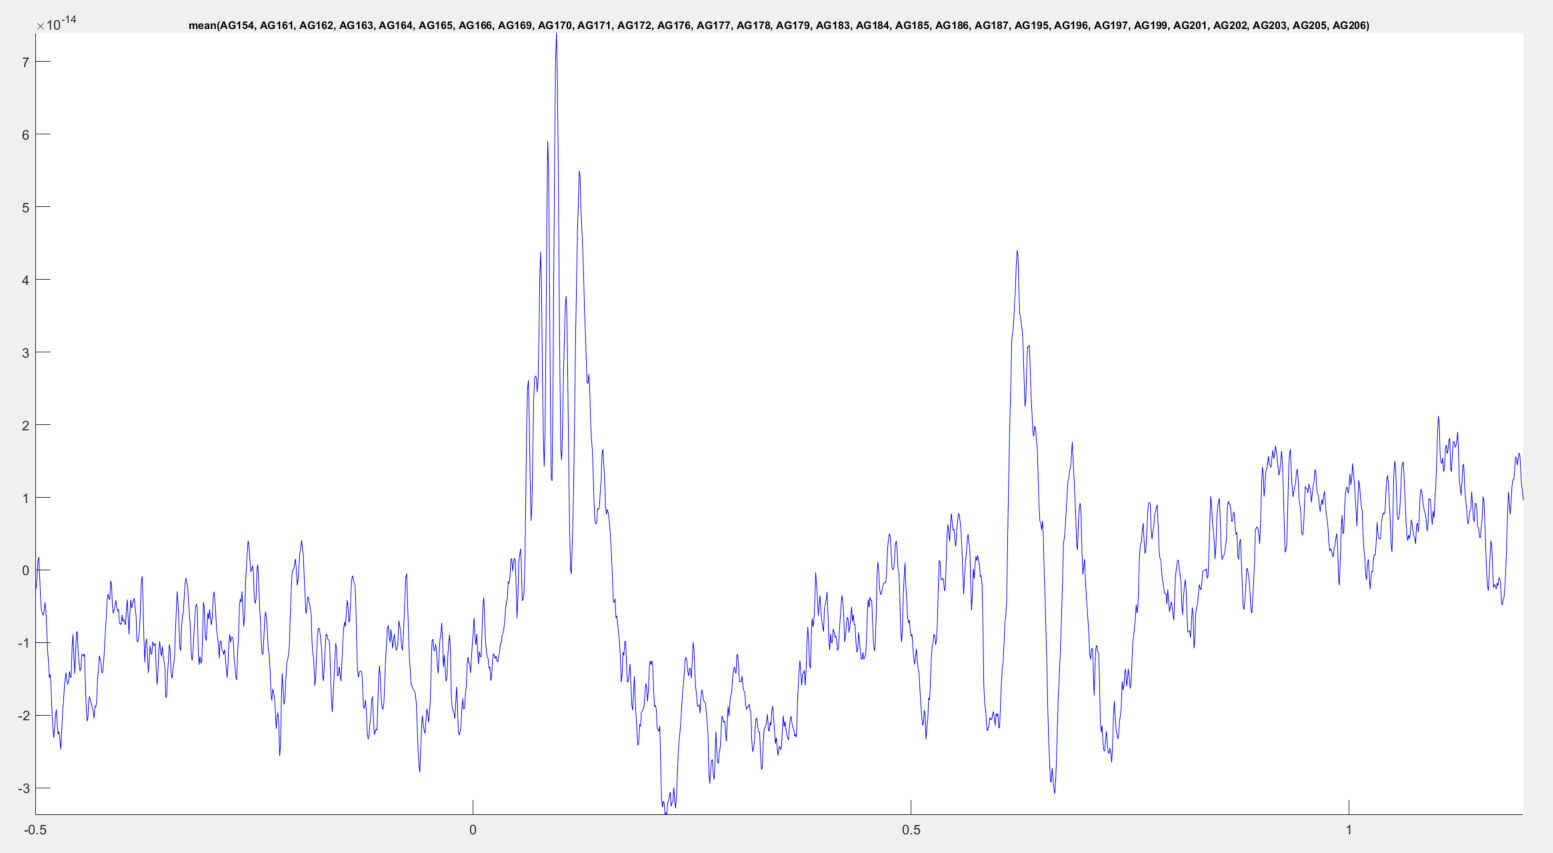

Select the M100 peak from the GUI then double click the selection to see the sensor topoplot averaged only at the selection peak time.
Observe then that the strongest magnetic field activity is in the Occipital lobe for the M100.

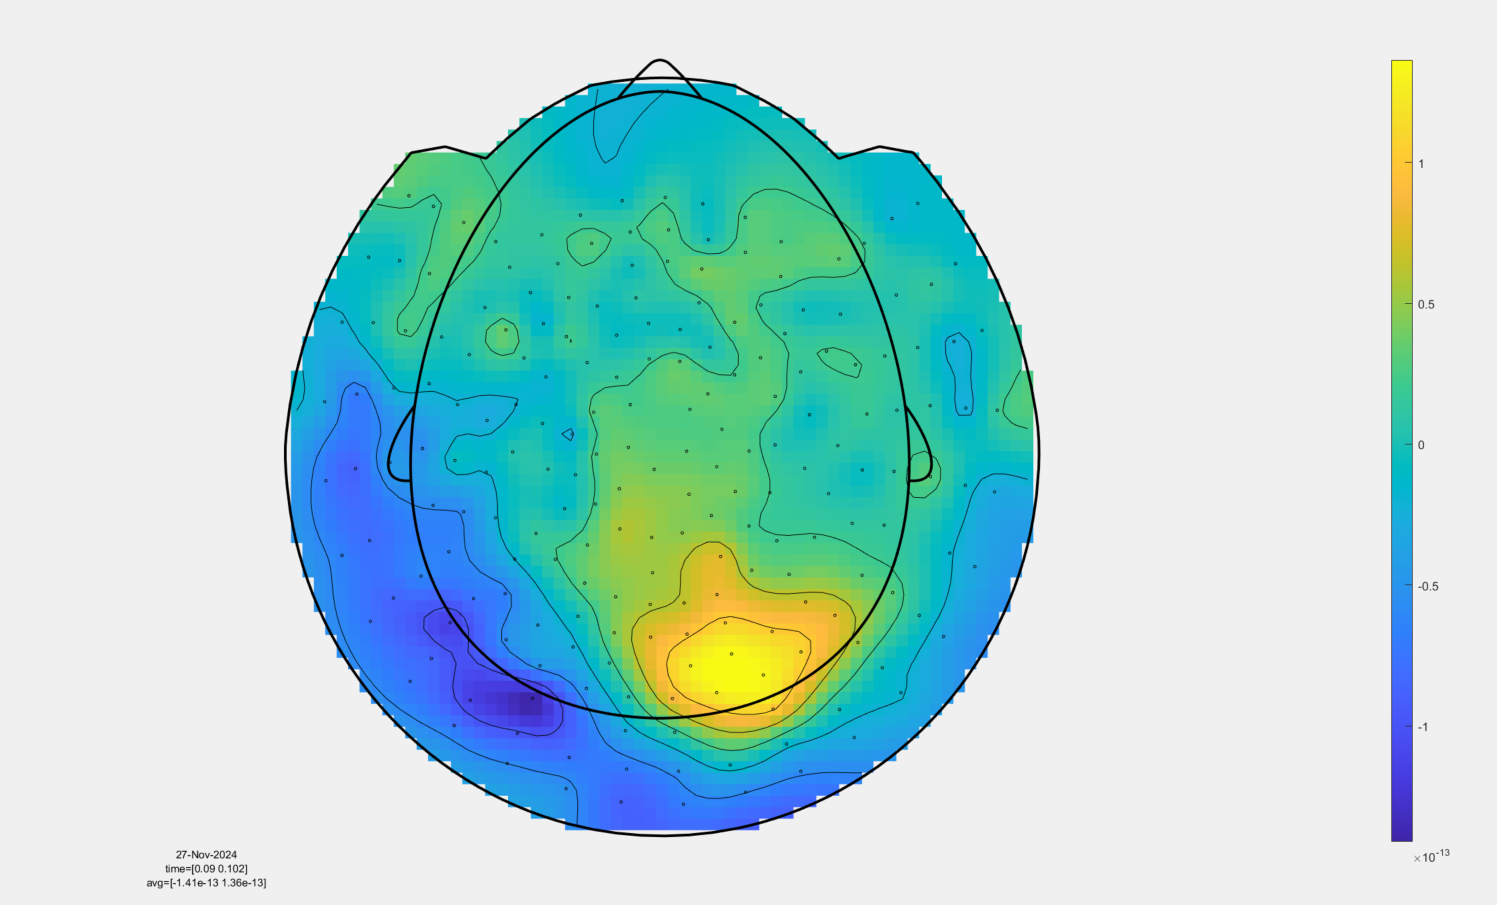